# Import

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from decisiontree import *

# Data Preprocessing

In [32]:
airbnb = pd.read_csv('data/airbnb_price_prediction/AB_NYC_2019.csv')
airbnb.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


In [33]:
# Fill string columns' na with unknown
airbnb['name'].fillna('unknown',inplace=True)
airbnb['host_name'].fillna('unknown',inplace=True)

# Fill numerical columns' na with the mean
airbnb['reviews_per_month'].fillna(0,inplace=True)
'''not filling last_review yet to use it for feature engineering'''

airbnb.isnull().sum()

#Creating that binary column (new listing : Yes/No)
airbnb["new_listing"] = 0
airbnb.loc[airbnb['last_review'].isnull(), 'new_listing'] = 1

#Now fill NA
airbnb['last_review'].fillna(0,inplace=True)

# Cast the last_review column to datetime
airbnb['last_review'] = pd.to_datetime(airbnb['last_review'])

# Create a column days since last review
airbnb['review_recency'] = (airbnb.last_review.max() - airbnb.last_review).dt.days

# Create columns that depict the availability category the listing belongs to
airbnb['all_year_avail'] = (airbnb['availability_365']>350).astype(int)
airbnb['low_avail'] = (airbnb['availability_365']< 12).astype(int)

# Create a variable that shows the number of months this listing has been in the platform
airbnb['months'] = airbnb['number_of_reviews']/airbnb['reviews_per_month']
airbnb['months'] = airbnb['months'].fillna(0)

# One-hot encode the room_type and neighbourhood_group
airbnb['type'] = 1
airbnb_pivoted = airbnb.pivot(columns='room_type',values='type').fillna(0)
airbnb = airbnb.join(airbnb_pivoted)
airbnb_pivoted = airbnb.pivot(columns='neighbourhood_group',values='type').fillna(0)
airbnb = airbnb.join(airbnb_pivoted)

# Label encoding of neighbourhood
airbnb['neighbourhood'] = airbnb['neighbourhood'].astype("category").cat.codes

# Drop the now unneccessary columns
airbnb = airbnb.drop(columns=['type','room_type','neighbourhood_group','availability_365','neighbourhood'])

# Getting rid of unimportant columns
airbnb.drop(columns=['id','name','host_id','host_name', 'last_review'],inplace=True)

airbnb.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,new_listing,review_recency,all_year_avail,low_avail,months,Entire home/apt,Private room,Shared room,Bronx,Brooklyn,Manhattan,Queens,Staten Island
0,40.64749,-73.97237,149,1,9,0.21,6,0,262,1,0,42.857143,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,40.75362,-73.98377,225,1,45,0.38,2,0,48,1,0,118.421053,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,40.80902,-73.94190,150,3,0,0.00,1,1,18085,1,0,0.000000,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,40.68514,-73.95976,89,1,270,4.64,1,0,3,0,0,58.189655,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,40.79851,-73.94399,80,10,9,0.10,1,0,231,0,1,90.000000,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Train-Test Split

In [34]:
# Isolate the predicting features
X = airbnb.drop(['price'], axis=1)

# We will transform to logarithm and predict that
y = np.log(airbnb['price']+1)

In [35]:
#Perform a split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [36]:
# Standardize the columns that are continuous
# Select only columns with numeric types
num_cols = X.select_dtypes(include=['int', 'float']).columns.tolist()

# Identify binary columns
binary_cols = []
for col in num_cols:
    if X[col].nunique() == 2:
        binary_cols.append(col)

# Identify continuous columns
continuous_cols = list(set(num_cols) - set(binary_cols))

# Scale the continuous columns, fitting them on the training set only
scaler = StandardScaler()
X_train[continuous_cols] = scaler.fit_transform(X_train[continuous_cols])

# Combine the binary and continuous columns into a single dataframe
X_train_scaled = pd.concat([X_train[continuous_cols], X_train[binary_cols]], axis=1)
X_test_scaled = pd.concat([X_test[continuous_cols], X_test[binary_cols]], axis=1)

# Regression Task

In [62]:
# 1.1 Check if a certain partition contains only one class?
def check_pure(data):

    if len(np.unique(data)) == 1:
        return True
    else:
        return False

In [63]:
# Data classifying through label y (for classifcation problem)
def classify_data(data):

    unique_classes, counts_unique_classes = np.unique(data, return_counts=True)

    index = counts_unique_classes.argmax()
    classification = unique_classes[index]
    
    return classification

In [79]:
X_train['latitude']

21681   -0.676063
26482   -1.253890
20859    0.246146
45464   -0.773408
22583    0.574182
           ...   
11284    2.160544
44732    0.196555
38158    0.997542
860      0.848769
15795    0.325125
Name: latitude, Length: 34226, dtype: float64

In [80]:
X_train.columns

Index(['latitude', 'longitude', 'minimum_nights', 'number_of_reviews',
       'reviews_per_month', 'calculated_host_listings_count', 'new_listing',
       'review_recency', 'all_year_avail', 'low_avail', 'months',
       'Entire home/apt', 'Private room', 'Shared room', 'Bronx', 'Brooklyn',
       'Manhattan', 'Queens', 'Staten Island'],
      dtype='object')

In [84]:
np.unique(X_train['latitude'])

array([-4.20749532, -4.08590546, -4.04421226, ...,  3.35752423,
        3.35789157,  3.38305443])

In [82]:
potential_splits = {}
for column in X_train.columns:
    potential_splits[column] = []
    values = X_train[column]
    unique_values = np.unique(values)
potential_splits

{'latitude': [],
 'longitude': [],
 'minimum_nights': [],
 'number_of_reviews': [],
 'reviews_per_month': [],
 'calculated_host_listings_count': [],
 'new_listing': [],
 'review_recency': [],
 'all_year_avail': [],
 'low_avail': [],
 'months': [],
 'Entire home/apt': [],
 'Private room': [],
 'Shared room': [],
 'Bronx': [],
 'Brooklyn': [],
 'Manhattan': [],
 'Queens': [],
 'Staten Island': []}

In [ ]:
# Enumerate all potential splits on X
def potential_splits(data):
    
    potential_splits = {}
    
    for column in data.columns:
        potential_splits[column] = []
        values = data[column]
        unique_values = np.unique(values)

        for index in range(len(unique_values)):
            if index != 0:
                current_value = unique_values[index]
                previous_value = unique_values[index - 1]
                potential_split = (current_value + previous_value) / 2
                
                potential_splits[column].append(potential_split)
    
    return potential_splits

### Reduction in Variance in Decision Tree
Reduction in Variance is a method for splitting the node used when the target variable is continuous, i.e., regression problems. It is called so because it uses variance as a measure for deciding the feature on which a node is split into child nodes.

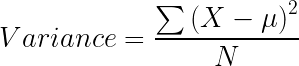

In [55]:
# 1.2 Create leaf if the branch is impure based on the task indicated
def create_leaf(y, task):

    if task == "regression":
        leaf = np.mean(y)
        
    # classfication    
    else:
        unique_classes, counts_unique_classes = np.unique(y, return_counts=True)
        index = counts_unique_classes.argmax()
        leaf = unique_classes[index]
    
    return leaf

In [60]:
np.mean(a)

c:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


price    1.0
dtype: float64

In [61]:
create_leaf(a, "regression")

c:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:3438: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


price    1.0
dtype: float64

In [27]:
tree = decision_tree_algorithm(X_train_scaled, ml_task="regression", max_depth=3)
accuracy = calculate_accuracy(X_test_scaled, tree)